In [1]:
#See: https://mc.ai/a-beginners-guide-to-build-stacked-autoencoder-and-tying-weights-with-it/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [3]:
#Loading the MNIST data
(X_train_orig, _), (X_test, _) = tfds.as_numpy(tfds.load(
    'mnist',
    split=['train', 'test'], 
    batch_size=-1, 
    as_supervised=True,
    data_dir="../data/cache/MNIST_data/",
    shuffle_files=True
))

print(X_train_orig.shape)
print(X_test.shape)
all_data = np.concatenate((X_train_orig, X_test))
print(all_data.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(70000, 28, 28, 1)


In [4]:
# Normalizing the RGB codes by dividing it to the max RGB value.
max_value = float(X_train_orig.max())
X_Train = X_train_orig.astype(np.float32) / max_value
X_Test = X_test.astype(np.float32) / max_value#Train and validation split
X_train, X_valid = X_Train[:-7000], X_Train[-7000:]
X_train.shape, X_valid.shape

((53000, 28, 28, 1), (7000, 28, 28, 1))

In [5]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")#Displays the original images and their reconstructions

In [6]:
def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [7]:
#Stacked Autoencoder with functional model
#encoder
inputs = keras.Input(shape=(28,28))
lr_flatten = keras.layers.Flatten()(inputs)
lr1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
lr2 = keras.layers.Dense(196, activation="selu")(lr1)#decoder
lr3 = keras.layers.Dense(392, activation="selu")(lr2)
lr4 = keras.layers.Dense(28 * 28, activation="sigmoid")(lr3)
outputs = keras.layers.Reshape([28, 28])(lr4)
stacked_ae = keras.models.Model(inputs,outputs)
stacked_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
stacked_ae.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 392)               307720    
_________________________________________________________________
dense_1 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_2 (Dense)              (None, 392)               77224     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               308112    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)           

In [8]:
h_stack = stacked_ae.fit(X_train, X_train, epochs=20,validation_data=[X_valid, X_valid])

Epoch 1/20
1657/1657 [==============================] - 6s 3ms/step - loss: 0.1329 - val_loss: 0.0000e+00
Epoch 2/20
1657/1657 [==============================] - 6s 3ms/step - loss: 0.0884 - val_loss: 0.0000e+00
Epoch 3/20
1657/1657 [==============================] - 6s 4ms/step - loss: 0.0810 - val_loss: 0.0000e+00
Epoch 4/20
1657/1657 [==============================] - 7s 4ms/step - loss: 0.0773 - val_loss: 0.0000e+00
Epoch 5/20
1657/1657 [==============================] - 7s 4ms/step - loss: 0.0752 - val_loss: 0.0000e+00
Epoch 6/20
1657/1657 [==============================] - 8s 5ms/step - loss: 0.0737 - val_loss: 0.0000e+00
Epoch 7/20
1657/1657 [==============================] - 9s 5ms/step - loss: 0.0726 - val_loss: 0.0000e+00
Epoch 8/20
1657/1657 [==============================] - 10s 6ms/step - loss: 0.0718 - val_loss: 0.0000e+00
Epoch 9/20
1657/1657 [==============================] - 10s 6ms/step - loss: 0.0711 - val_loss: 0.0000e+00
Epoch 10/20
1657/1657 [=====================

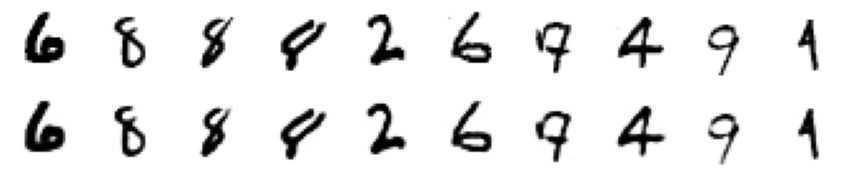

In [9]:
show_reconstructions(stacked_ae)

In [10]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros",shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [11]:
dense_1 = keras.layers.Dense(392, activation="selu")
dense_2 = keras.layers.Dense(196, activation="selu")#tied_encoder
inputs = keras.Input(shape=(28,28))
l_flatten = keras.layers.Flatten()(inputs)
l_en1 = dense_1(l_flatten)
l_en2 = dense_2(l_en1)#tied_decoder
l_dc1 = DenseTranspose(dense_2, activation="selu")(l_en2)
l_dc2 = DenseTranspose(dense_1, activation="sigmoid")(l_dc1)
outputs = keras.layers.Reshape([28, 28])(l_dc2)
tied_ae = keras.models.Model(inputs, outputs)
tied_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
tied_ae.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_5 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_transpose (DenseTransp (None, 392)               77420     
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 784)               308504    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)           

Epoch 1/20
1657/1657 [==============================] - 9s 6ms/step - loss: 0.1083 - val_loss: 0.0000e+00
Epoch 2/20
1657/1657 [==============================] - 10s 6ms/step - loss: 0.0780 - val_loss: 0.0000e+00
Epoch 3/20
1657/1657 [==============================] - 10s 6ms/step - loss: 0.0739 - val_loss: 0.0000e+00
Epoch 4/20
1657/1657 [==============================] - 9s 5ms/step - loss: 0.0719 - val_loss: 0.0000e+00
Epoch 5/20
1657/1657 [==============================] - 9s 5ms/step - loss: 0.0707 - val_loss: 0.0000e+00
Epoch 6/20
1657/1657 [==============================] - 8s 5ms/step - loss: 0.0699 - val_loss: 0.0000e+00
Epoch 7/20
1657/1657 [==============================] - 8s 5ms/step - loss: 0.0692 - val_loss: 0.0000e+00
Epoch 8/20
1657/1657 [==============================] - 8s 5ms/step - loss: 0.0687 - val_loss: 0.0000e+00
Epoch 9/20
1657/1657 [==============================] - 9s 5ms/step - loss: 0.0683 - val_loss: 0.0000e+00
Epoch 10/20
1657/1657 [=====================

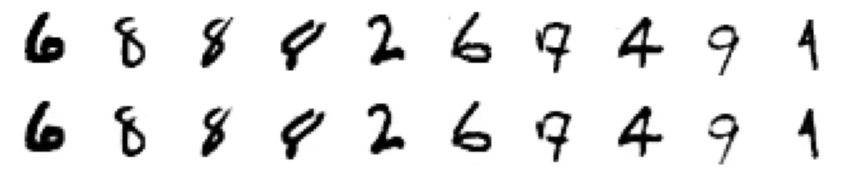

In [12]:
#fit the model 
h_tied = tied_ae.fit(X_train, X_train, epochs=20,validation_data=[X_valid, X_valid])# reconstruct the image
show_reconstructions(tied_ae)